In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from utils import reset_seed, display_compare

import os

# tf.config.experimental.get_visible_devices()

## Linear Autoencoders

Firs prepare a nice synthetic dataset

Data shape: (500, 3)


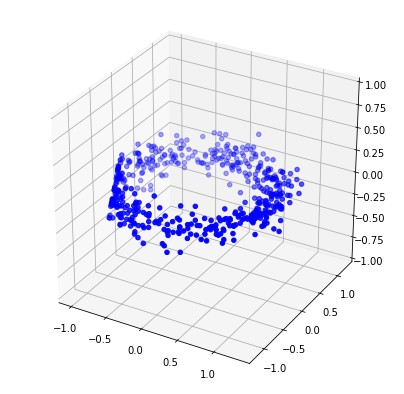

In [3]:
reset_seed()

N = 500
u = np.random.uniform(low=0, high=2.0 * np.pi, size=N)
v = np.random.normal(0, 0.25, size=N)

x = (1 + 0.5 * v * np.cos(u / 2.0)) * np.cos(u)
y = (1 + 0.5 * v * np.cos(u / 2.0)) * np.sin(u)
z = 0.5 * v * np.sin(u / 2.0)

# stack all together in a table
data = np.vstack((x,y,z)).transpose()
print("Data shape:", data.shape)

# Plot 3D
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.scatter(*np.hsplit(data, 3), c='b', marker='o')
ax.set_zlim(-1, 1)

plt.show()

Now we define our first **linear autoencoder**:

In [4]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

encoder = Sequential([Dense(2, input_shape=[3])])
decoder = Sequential([Dense(3, input_shape=[2])])
autoencoder = Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=SGD(1.))
autoencoder.fit(data, data, epochs=6, verbose=0)

coded_data = encoder.predict(data)

Both decoder and encoder are linear.. The codings obtained training the model should be very similar to the one obtained by PCA.

In [5]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

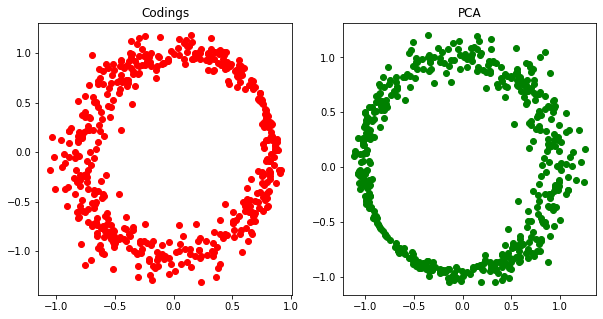

In [6]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(*np.hsplit(coded_data, 2), c='r', marker='o')
ax1.set_title("Codings")
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(*np.hsplit(pca_data, 2), c='g', marker='o')
ax2.set_title("PCA")
plt.show()

# Images reconstruction

In [7]:
from sklearn.model_selection import train_test_split
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train_full = np.float32(x_train_full/255.)
x_test       = np.float32(x_test/255.)
x_train, x_val,  y_train, y_val  = train_test_split(x_train_full, y_train_full, random_state=0)
print(x_train.shape)

(45000, 28, 28)


In [8]:
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.nn import leaky_relu

def get_dense_autoencoder(latent_dim=30, activation=leaky_relu):
    encoder = Sequential([
        Flatten(input_shape=[28, 28]),
        Dense(100, activation=activation),
        Dense(latent_dim, activation=activation),
    ])
    decoder = Sequential([
        Dense(100, activation=activation, input_shape=[latent_dim]),
        Dense(28 * 28, activation="sigmoid"),
        Reshape([28, 28])
    ])
    return Sequential([encoder, decoder])

In [40]:
reset_seed()

dense_ae = get_dense_autoencoder()
dense_ae.compile(loss="binary_crossentropy", optimizer=SGD(1.))
dense_ae.fit(x_train, x_train, epochs=20, validation_data=(x_val, x_val))

Epoch 1/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3822 - val_loss: 0.3305
Epoch 2/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3184 - val_loss: 0.3130
Epoch 3/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3082 - val_loss: 0.3058
Epoch 4/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3025 - val_loss: 0.3020
Epoch 5/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.2989 - val_loss: 0.2988
Epoch 6/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.2958 - val_loss: 0.2952
Epoch 7/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.2932 - val_loss: 0.2932
Epoch 8/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.2913 - val_loss: 0.2919
Epoch 9/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.2896 - val_loss: 0.2903
Epoch 10/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.288

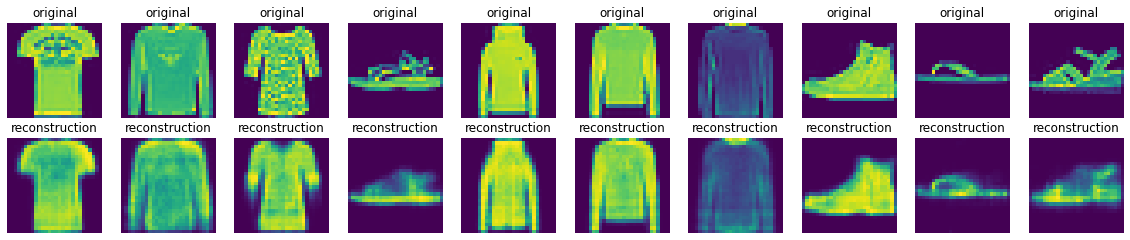

In [42]:
dense_rec = dense_ae.predict(x_val)

display_compare(x_val, dense_rec, names=["original", "reconstruction"])

In [11]:
def rmse_loss(y_true, y_pred):
    return tf.math.sqrt(tf.reduce_mean(tf.math.square(y_true-y_pred)))

reconstructions = []
for loss in ["mse", "mae", rmse_loss, "binary_crossentropy"]:
    reset_seed()
    autoencoder = get_dense_autoencoder()
    autoencoder.compile(loss=loss, optimizer=SGD(1.))
    autoencoder.fit(x_train, x_train, epochs=20, verbose=0)
    reconstructions.append(autoencoder.predict(x_val))

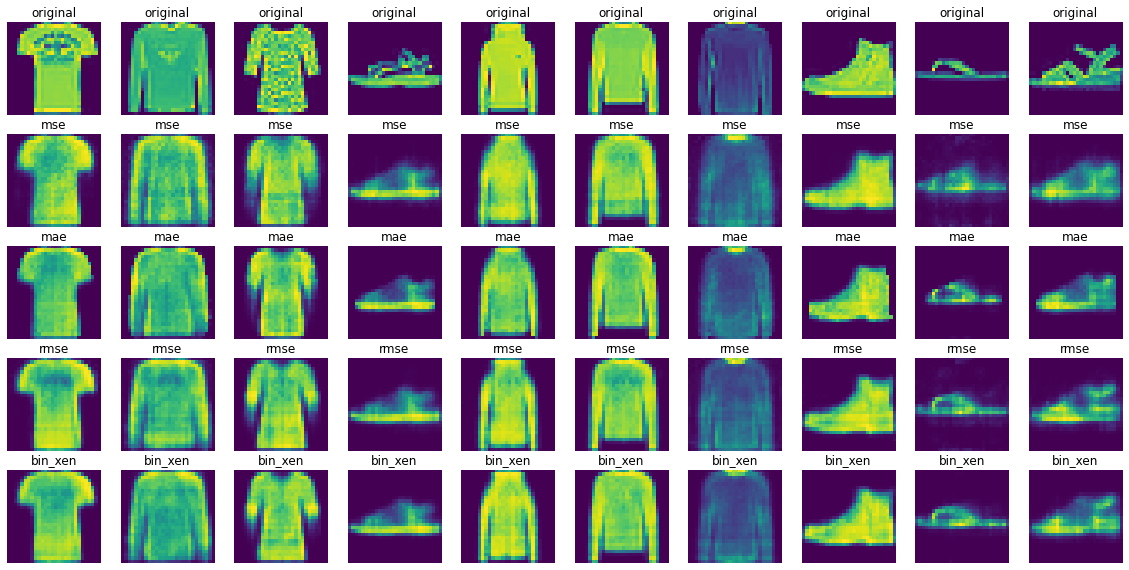

In [12]:
display_compare(x_val, *reconstructions, names=["original", "mse", "mae", "rmse", "bin_xen"])

# Convolutional Autoencoders

In [37]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

def get_conv_autoencoder(activation=leaky_relu):
    encoder = Sequential([
        Reshape([28, 28, 1], input_shape=[28, 28]),
        Conv2D(16, 3, strides=2, padding="same", activation=activation),
        Conv2D(32, 3, strides=2, padding="same", activation=activation),
        Conv2D(64, 3, strides=2, padding="same", activation=activation),
    ])
    
    decoder = Sequential([
        Conv2DTranspose(32, 3, strides=2, padding="same", activation=activation, input_shape=[3, 3, 64]),
        Conv2DTranspose(16, 3, strides=2, padding="same", activation=activation),
        Conv2DTranspose(1, 3, strides=2, padding="same", activation="sigmoid"),
        Reshape([28, 28])
    ])
    return Sequential([encoder, decoder])

In [49]:
reset_seed()
conv_ae = get_conv_autoencoder()
conv_ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.SGD(.1))
conv_ae.layers[0].summary()
conv_ae.layers[1].summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 3, 64)          18496     
Total params: 23,296
Trainable params: 23,296
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_39 (Conv2DT (None, 7, 7, 32)          18464     
__________________________

In [47]:
conv_ae.fit(x_train, x_train, epochs=20, verbose=1, validation_data=(x_val, x_val))

Epoch 1/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.5319 - val_loss: 0.3599
Epoch 2/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.3236 - val_loss: 0.3059
Epoch 3/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.2997 - val_loss: 0.2945
Epoch 4/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.2909 - val_loss: 0.2874
Epoch 5/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.2852 - val_loss: 0.2832
Epoch 6/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.2812 - val_loss: 0.2805
Epoch 7/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.2784 - val_loss: 0.2782
Epoch 8/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.2762 - val_loss: 0.2758
Epoch 9/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.2743 - val_loss: 0.2738
Epoch 10/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.273

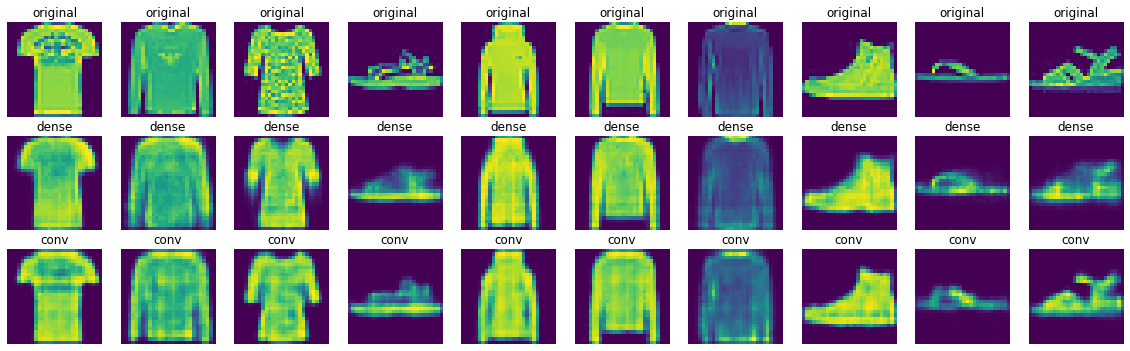

In [48]:
conv_rec = conv_ae.predict(x_val)

display_compare(x_val, dense_rec, conv_rec, names=["original", "dense", "conv"])

## Codings representation

In [50]:
tf.random.set_seed(0)
np.random.seed(0)

low_ae = get_dense_autoencoder(latent_dim=2)
low_ae.compile(loss="binary_crossentropy", optimizer=SGD(1.))
low_ae.fit(x_train, x_train, epochs=20, verbose=0)

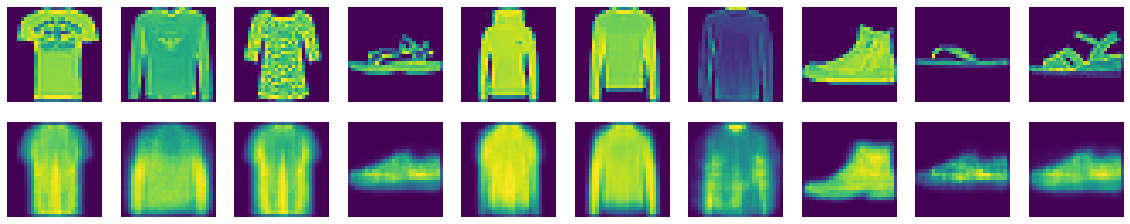

In [51]:
rec_low_ae = low_ae.predict(x_val)
display_compare(x_val, rec_low_ae)

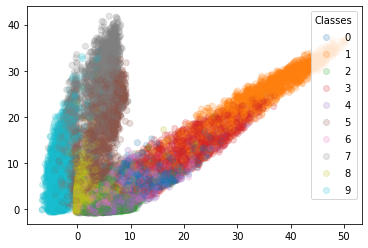

In [52]:
encoder = low_ae.layers[0]
codings = encoder.predict(x_val)
scatter = plt.scatter(*np.hsplit(codings,2), c=y_val, cmap="tab10", alpha=0.2)
legend1 = plt.legend(*scatter.legend_elements(), loc="best", title="Classes")

In [53]:
encoder = dense_ae.layers[0]
codings = encoder.predict(x_val)
print(codings.shape)

(15000, 30)


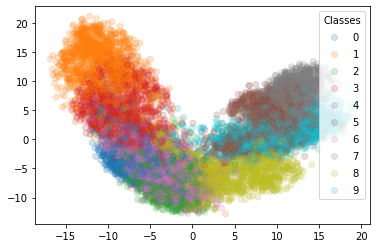

In [56]:
pca = PCA(n_components=2)
pca_out = pca.fit_transform(codings)
scatter = plt.scatter(*np.hsplit(pca_out,2), c=y_val, cmap="tab10", alpha=0.2)
legend1 = plt.legend(*scatter.legend_elements(), loc="best", title="Classes")

(15000, 3, 3, 64)
(15000, 576)


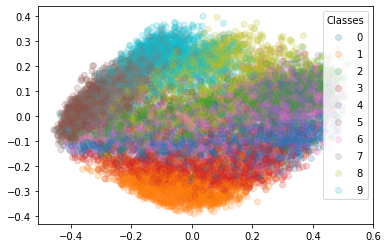

In [62]:
encoder = conv_ae.layers[0]
codings = encoder.predict(x_val)
print(codings.shape)
flat_codings = codings.reshape((codings.shape[0],-1))
print(flat_codings.shape)
pca = PCA(n_components=2)
pca_out = pca.fit_transform(flat_codings)
scatter = plt.scatter(*np.hsplit(pca_out,2), c=y_val, cmap="tab10", alpha=0.2)
legend1 = plt.legend(*scatter.legend_elements(), loc="best", title="Classes")